In [12]:
from pydriller import Repository
import subprocess
import csv
import os


part c

In [ ]:

repos = [
    r"django-imagekit",
    r"deep-learning-for-image-processing",
    r"pyimagej"
]
output_file = "lab4_diff_dataset.csv"
with open(output_file, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow([
        "repo",
        "old_file_path",
        "new_file_path",
        "commit_sha",
        "parent_commit_sha",
        "commit_message",
        "diff_myers",
        "diff_hist"
    ])


def run_git_diff(repo_path, commit, parent, algo):
    """
    Runs git diff with the given algorithm (myers or histogram).
    """
    try:
        diff_output = subprocess.check_output(
            ["git", "-C", repo_path, "diff", parent, commit, f"--diff-algorithm={algo}", "-w", "--ignore-blank-lines"],
            stderr=subprocess.DEVNULL,
            text=True,
            encoding="utf-8",
            errors="ignore"
        )
        return diff_output
    except subprocess.CalledProcessError:
        return ""


for repo_path in repos:
    print(f"Processing repository: {repo_path}")
    i=0
    for commit in Repository(repo_path).traverse_commits():
        if i%100==0:
            print(i)
        i+=1
        for mod in commit.modified_files:
            # Skip if file paths are None (e.g., file deletions/renames)
            old_path = mod.old_path if mod.old_path else ""
            new_path = mod.new_path if mod.new_path else ""
            
            # Get parent commit
            if not commit.parents:
                continue  # skip root commits
            parent = commit.parents[0]

            # Run git diff with Myers and Histogram
            diff_myers = run_git_diff(repo_path, commit.hash, parent, "myers")
            diff_hist = run_git_diff(repo_path, commit.hash, parent, "histogram")

            # Write row into CSV
            with open(output_file, "a", newline="", encoding="utf-8") as f:
                writer = csv.writer(f)
                writer.writerow([
                    os.path.basename(repo_path),
                    old_path,
                    new_path,
                    commit.hash,
                    parent,
                    commit.msg.strip(),
                    diff_myers,
                    diff_hist
                ])


Processing repository: django-imagekit
0
100
200
300
400
500
600
700
800
900
1000
1100
Processing repository: deep-learning-for-image-processing
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
Processing repository: pyimagej
0
100
200
300
400
500
600
700
800
900
1000
1100
1200


part d


In [14]:
import pandas as pd

input_file = "lab4_diff_dataset.csv"
output_file = "lab4_diff_dataset_with_discrepancy.csv"

df = pd.read_csv(input_file)

df["Discrepancy"] = df.apply(
    lambda row: "Yes" if str(row["diff_myers"]).strip() != str(row["diff_hist"]).strip() else "No",
    axis=1
)

df.to_csv(output_file, index=False)
print(f"Updated dataset with discrepancy column saved to {output_file}")


Updated dataset with discrepancy column saved to lab4_diff_dataset_with_discrepancy.csv


In [ ]:

total_rows = len(df)
discrepancies = (df["Discrepancy"] == "Yes").sum()

# Percentage discrepancy
if total_rows > 0:
    percent_discrepancy = (discrepancies / total_rows) * 100
else:
    percent_discrepancy = 0

print(f"Total rows: {total_rows}")
print(f"Discrepancies: {discrepancies}")
print(f"Percentage discrepancy: {percent_discrepancy:.2f}%")


Total rows: 6203
Discrepancies: 661
Percentage discrepancy: 10.66%


In [11]:
df.head()

,repo,old_file_path,new_file_path,commit_sha,parent_commit_sha,commit_message,diff_myers,diff_hist,Discrepancy
0,django-imagekit,src/imagekit/models.py,src/imagekit/models.py,37b8b5355f1b85a939ea789ef0b8316776766376,5b069cc289f11fd82c9e7e47d7659875b3e373c9,Updated models.py,diff --git a/src/imagekit/models.py b/src/imag...,diff --git a/src/imagekit/models.py b/src/imag...,No
1,django-imagekit,src/imagekit/models.py,src/imagekit/models.py,0a3f964d180f9f8435451f68a0922b6e198ace9f,37b8b5355f1b85a939ea789ef0b8316776766376,Added test.py,diff --git a/src/imagekit/models.py b/src/imag...,diff --git a/src/imagekit/models.py b/src/imag...,Yes
2,django-imagekit,NaN,src/imagekit/tests.py,0a3f964d180f9f8435451f68a0922b6e198ace9f,37b8b5355f1b85a939ea789ef0b8316776766376,Added test.py,diff --git a/src/imagekit/models.py b/src/imag...,diff --git a/src/imagekit/models.py b/src/imag...,Yes
3,django-imagekit,src/imagekit/models.py,src/imagekit/models.py,78dfae2daed97967c74b93ba8528b222063fd52f,0a3f964d180f9f8435451f68a0922b6e198ace9f,Added Metaclass,diff --git a/src/imagekit/models.py b/src/imag...,diff --git a/src/imagekit/models.py b/src/imag...,No
4,django-imagekit,src/imagekit/tests.py,src/imagekit/tests.py,78dfae2daed97967c74b93ba8528b222063fd52f,0a3f964d180f9f8435451f68a0922b6e198ace9f,Added Metaclass,diff --git a/src/imagekit/models.py b/src/imag...,diff --git a/src/imagekit/models.py b/src/imag...,No


part e

Mismatch Statistics:
FileCategory
Source Code    346
Other          200
Test Code       84
README          30
LICENSE          1
Name: count, dtype: int64


/tmp/ipykernel_90420/276019323.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatches["FileCategory"] = mismatches["new_file_path"].apply(categorize_file)


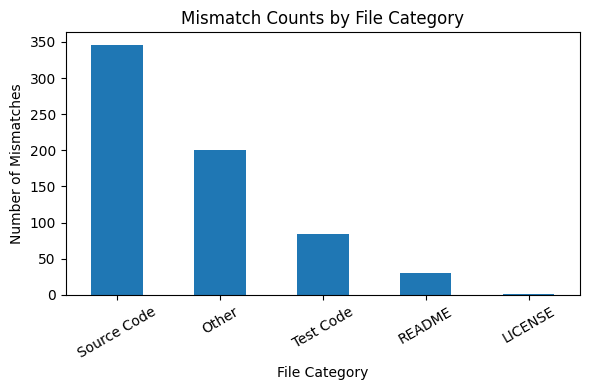

In [ ]:
import matplotlib.pyplot as plt

mismatches = df[df["Discrepancy"] == "Yes"]

def categorize_file(path):
    if not isinstance(path, str):
        return "Other"
    filename = path.lower()
    if "test" in filename:         
        return "Test Code"
    elif filename.endswith(".py") or filename.endswith(".java") or filename.endswith(".cpp"):
        return "Source Code"
    elif "readme" in filename:
        return "README"
    elif "license" in filename:
        return "LICENSE"
    else:
        return "Other"

mismatches["FileCategory"] = mismatches["new_file_path"].apply(categorize_file)

# Count mismatches per category
stats = mismatches["FileCategory"].value_counts()

print("Mismatch Statistics:")
print(stats)

plt.figure(figsize=(6,4))
stats.plot(kind="bar", rot=30)
plt.title("Mismatch Counts by File Category")
plt.xlabel("File Category")
plt.ylabel("Number of Mismatches")
plt.tight_layout()
plt.savefig("mismatch_statistics.png")
plt.show()


Summary of Discrepancies by File Category:
              Total Files  Mismatches  % Discrepancy
FileCategory                                        
Source Code          3380         346          10.24
Other                1301         200          15.37
Test Code            1036          84           8.11
README                477          30           6.29
LICENSE                 9           1          11.11


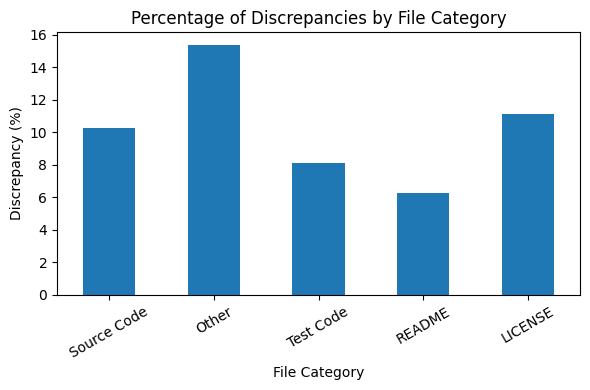

In [ ]:

df["FileCategory"] = df["new_file_path"].apply(categorize_file)

total_counts = df["FileCategory"].value_counts()

mismatch_counts = df[df["Discrepancy"] == "Yes"]["FileCategory"].value_counts()

percent_discrepancy = (mismatch_counts / total_counts * 100).fillna(0)

summary = pd.DataFrame({
    "Total Files": total_counts,
    "Mismatches": mismatch_counts,
    "% Discrepancy": percent_discrepancy.round(2)
}).fillna(0)

print("Summary of Discrepancies by File Category:")
print(summary)

plt.figure(figsize=(6,4))
percent_discrepancy.plot(kind="bar", rot=30)
plt.title("Percentage of Discrepancies by File Category")
plt.xlabel("File Category")
plt.ylabel("Discrepancy (%)")
plt.tight_layout()
plt.savefig("percent_discrepancy.png")
plt.show()
